# CNN classification

The process of building a convolutional neural network for image classification is described here.

In [25]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision.transforms as T
from torchvision.datasets import CIFAR10

import matplotlib.pyplot as plt

from IPython.display import clear_output
from tqdm import tqdm

## Data

For this notebook, `CIFAR10` is used. So it's loaded in the following cell.

In [5]:
train_dataset = CIFAR10(
    './cifar10', 
    train=True, 
    transform=T.ToTensor()
)
valid_dataset = CIFAR10(
    './cifar10', 
    train=False,
    transform=T.ToTensor()
)

There are some tricks at the data level:

- Both training and validation data need to be better normalised;
- For the training data, we added some augmentations that usually make the model more robust.

In [9]:
means = (train_dataset.data / 255).mean(axis=(0, 1, 2))
stds = (train_dataset.data / 255).std(axis=(0, 1, 2))

train_transforms = T.Compose(
    [
        T.AutoAugment(T.AutoAugmentPolicy.CIFAR10),
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)

test_transforms = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)

train_dataset.transforms = train_transforms
valid_dataset.transforms = test_transforms

## Architecture

This is a really simple, but a bit bulky architecture.

In [8]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=3, 
                out_channels=32, 
                kernel_size=3, 
                padding=1
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(
                in_channels=32, 
                out_channels=32, 
                kernel_size=3, 
                padding=1
            ),  # 32 x 32 x 32
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.MaxPool2d(2),  # 16 x 16 x 32
            nn.Dropout2d(p=0.2),

            nn.Conv2d(
                in_channels=32, 
                out_channels=64, 
                kernel_size=3, 
                padding=1
            ),  # 16 x 16 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(
                in_channels=64, 
                out_channels=64, 
                kernel_size=3, 
                padding=1
            ),  # 16 x 16 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2),  # 8 x 8 x 32
            nn.Dropout2d(p=0.2),
            
            nn.Conv2d(
                in_channels=64, 
                out_channels=128, 
                kernel_size=3, 
                padding=1
            ),  # 8 x 8 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(
                in_channels=128, 
                out_channels=128, 
                kernel_size=3, 
                padding=1
            ),  # 8 x 8 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.MaxPool2d(2),  # 4 x 4 x 128
            nn.Dropout2d(p=0.2),

            nn.Flatten(),

            nn.Linear(4 * 4 * 128, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.3),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.net(x)

## Fitting

Here is dscribed everything we needed to fit model. Everything is quite simple except learning the scheduler. It's a tool that allows to reduce the steps of the optimiser to get better optimisation results.

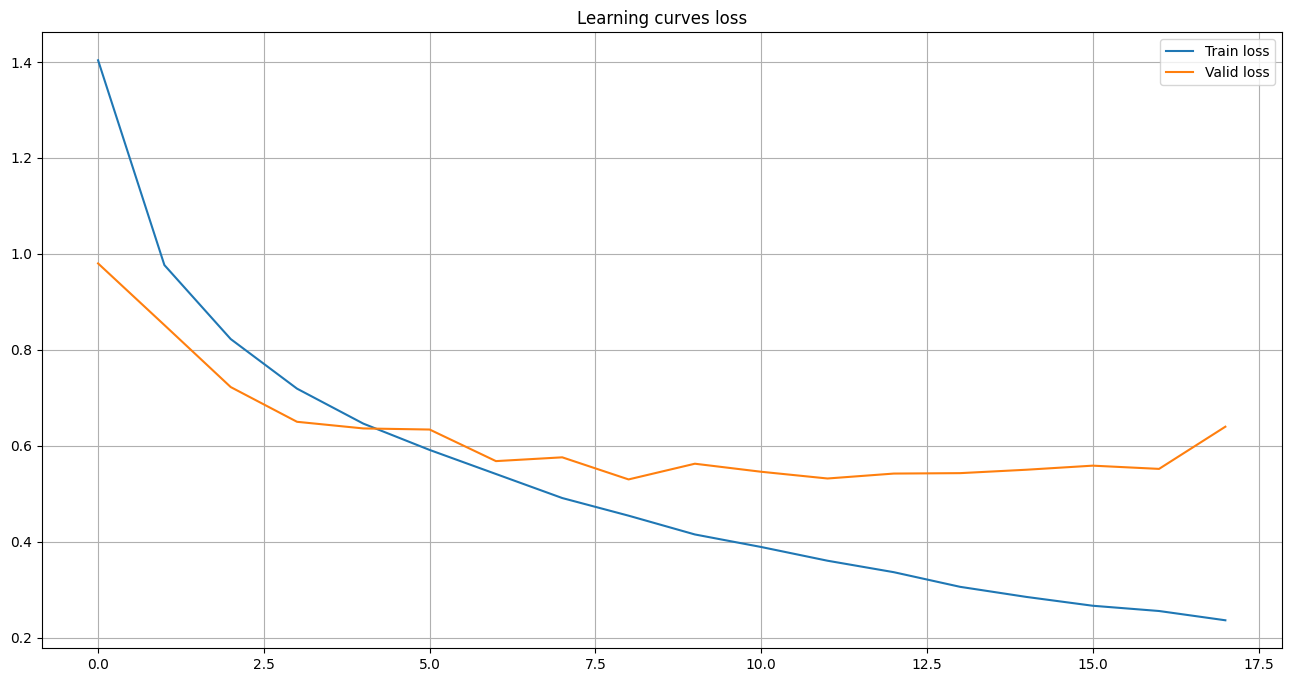

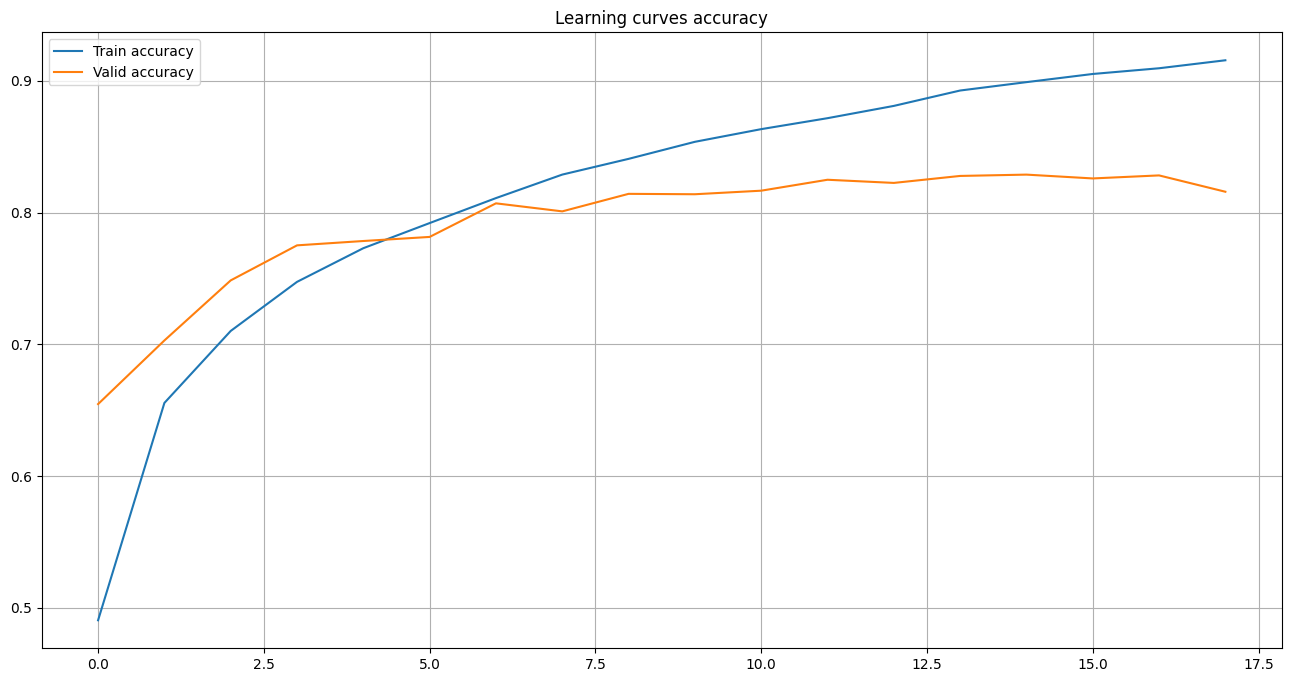

In [26]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25)
loss_fn = nn.CrossEntropyLoss()

def train(model) -> tuple[float, float]:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, desc='Train'):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()

        loss.backward()

        optimizer.step()
        
        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy


@torch.inference_mode()
def evaluate(model, loader) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

train_loader = DataLoader(
    train_dataset, 
    batch_size=128, 
    shuffle=True, 
    num_workers=8, 
    pin_memory=True
)
valid_loader = DataLoader(
    valid_dataset, 
    batch_size=128, 
    shuffle=False, 
    num_workers=8, 
    pin_memory=True
)

train_loss_history, valid_loss_history = [], []
train_accuracy_history, valid_accuracy_history = [], []

for epoch in range(30):
    train_loss, train_accuracy = train(model)
    valid_loss, valid_accuracy = evaluate(model, valid_loader)

    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)

    train_accuracy_history.append(train_accuracy)
    valid_accuracy_history.append(valid_accuracy)

    clear_output()

    plot_stats(
        train_loss_history, valid_loss_history,
        train_accuracy_history, valid_accuracy_history,
        "Learning curves"
    )
    if valid_accuracy > 0.88:
        break

    scheduler.step()